*Francisco Javier Sáez Maldonado*

In [1]:
from appsa_pr1 import *
import numpy as np
from os import listdir
from os.path import isfile, join

%load_ext autoreload
%autoreload 2

# Audio segment representation and annotations

## Wave shapes and audio features

We begin by plotting a random signal of the validation set. We fix the numpy random seed so that the same signal appears in every execution (I have noticed that the signal may change with different versions of `NumPy`). If we change the seed, the plotted signal would change. Also, recall that the `plot_waveform` function returns the loaded signal, which we can use to extract useful information.

In [2]:
np.random.seed(123)
path = DATASET_PATH + AUDIO_SUBPATH
audio_names = [f for f in listdir(path) if isfile(join(path, f))]
choice = np.random.choice(audio_names,1)[0]
print(choice)

Y_HDolAn2_us_60.000_70.000.wav


When we listen to this audio, we can recognize a few events:

- In the first 3 seconds, a knock on certain type of surface sounds.
- After that, a door bell rings
- Lastly, around second $7$, a few people say "Little pigs, little pigs".

Num samples     = 441000
Sample rate f_s = 44100
Total duration  = 10.0


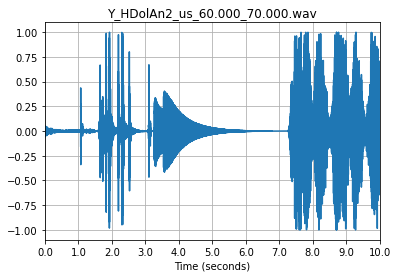

In [3]:
signal = plot_waveform(choice)
print("Num samples     = {}".format(signal[0].size))
print("Sample rate f_s = {}".format(signal[1]))
print("Total duration  = {}".format(signal[0].size / signal[1]))

- What is the sample rate $f_s$ ?

The load function from `librosa` returns both the audio timeseries `y` and the sample rate `f_s`. In this case,the  **sample rate** of $44100$ samples per second.

- What is the duration of the audio file in seconds?

We can compute it by dividing the total number of samples by the sample rate, obtaining a duration of $10$ seconds.

- Include the obtained figure in this document

We can see the obtained figure above.

### Mel-spectrogram

Let us plot the **mel-spectrogram**. This is obtained applying the *Fast Fourier transform* using overlapping windowed segments of the audio signal, and the converting the $y$ axis (frequency) to a **mel-scale**. We use the same audio used in the previous case (we replace in the filename the last three characters for the ones needed for the `NumPy` extension).

We include the figure and some variables that will help us on the following questions.

Mel shape : (864, 64)
Seconds   : 10.046511627906977
Total size: 55296


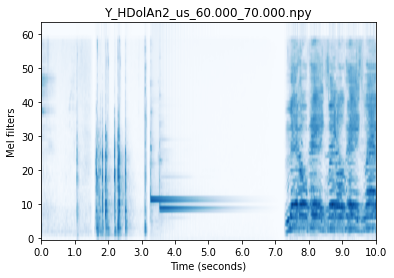

In [4]:
choice_feats_filename = choice[:-3] + 'npy'
mel = plot_melgram(choice_feats_filename)
print("Mel shape : {}".format(mel.shape))
print("Seconds   : {}".format(mel.shape[0]/86))
print("Total size: {}".format(np.prod(mel.shape)))

- How many temporal frames does the mel-spectrogram representation contains?

Inspecting the shape of the mel-spectrogram, we found that it has $864$ frames.

- How many mel filters are represented in the obtained mel-spectrogram?

Again, inspecting the shape we found that we are representing $64$ filters.

- Compare the waveform size with the mel-spectrogram size in term of the number of samples in each representation

We have seen that the original signal has $441000$ samples and the mel-spectrogram has $864 \cdot 64 = 55296$ elements, which is a little bit more of $1/10$ of the original signal, reducing the size significantly.

## Event annotation

In this section we will load the annotations of the considered example and we will make some comments about them. Let us begin by loading them.
We also assume that in the events with `NaN` annotations (no annotations for this event), we can use $0.0$ in all the cases.

In [5]:
anno_path = DATASET_PATH + META_SUBPATH + META_FILE

import pandas as pd
df = pd.read_csv(anno_path, sep = "\t", header = 0)
df = df.fillna(0)
print(df.head)

<bound method NDFrame.head of                               filename  onset  offset     event_label
0     Y00pbt6aJV8Y_350.000_360.000.wav  0.000   9.971  Vacuum_cleaner
1       Y00pK0GMmE9s_70.000_80.000.wav  0.000  10.000  Vacuum_cleaner
2       Y02sD1KJeoGA_50.000_60.000.wav  0.000  10.000          Frying
3       Y0bjUq9XMMmQ_30.000_40.000.wav  0.000  10.000          Frying
4       Y0cH_NlhhMAs_30.000_40.000.wav  1.710   6.005             Cat
...                                ...    ...     ...             ...
4246  Yb8GxUkjLSUY_628.000_638.000.wav  4.772   5.228          Speech
4247  Yb8GxUkjLSUY_628.000_638.000.wav  5.606   6.360          Speech
4248  Yb8GxUkjLSUY_628.000_638.000.wav  7.644   8.220          Speech
4249  Yb8GxUkjLSUY_628.000_638.000.wav  8.524   9.391          Speech
4250    Y86owBlJa8f0_24.000_34.000.wav  0.000   0.000               0

[4251 rows x 4 columns]>


We can now select the annotations for our audio

In [6]:
choice_annotations = df.loc[df['filename'] == choice]
print(choice_annotations)

                           filename  onset  offset         event_label
530  Y_HDolAn2_us_60.000_70.000.wav  3.224   5.706  Alarm_bell_ringing
531  Y_HDolAn2_us_60.000_70.000.wav  7.253   9.983              Speech


As we can see, there are two events in our audio:

- One in the interval of time $[3.224,5.706]$ that is an `Alarm_bell_ringing`
- The second one is in the interval of time $[7.253,9.983]$ that is `Speech`. 

Let us plot the annotations:

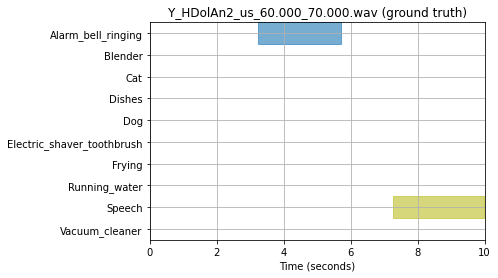

In [7]:
plot_labels(choice)

- Is there overlapping between the audio events?

We already saw in the previous description with the time intervals that there is no overlapping between the tags. The plot of the labels confirms this.

- Compare the waveform and the mel-spectrogram with the annotation, and associate the annotated audio events with the different parts of the representations

To achieve this, it we will plot the three previous graphs stacked:

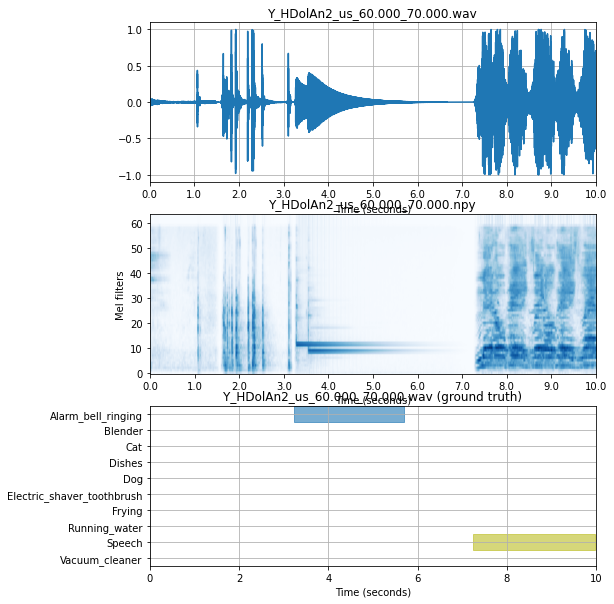

In [8]:
fig,ax = plt.subplots(3,1,figsize = (8,10))
_ = plot_waveform(choice, ax[0])
_ = plot_melgram(choice_feats_filename, ax[1])
plot_labels(choice, ax[2])

We can appreciate that there is a direct correspondence between the audio waveform, the mel-spectrogram, the labels and the audio. As we can see, when the alarm bell rings, the mel-spectrogram turns blue in the filters $[9-13]$ approximately. Also, there is a big perturbation in the waveform. The same occurs when the people start talking (as we mentioned in the description of the listened audio), there is a huge change in the waveform plot, the mel-spectrogram turns blue and the label starts, all in approximately the same vertical point.


# Acoustic event dectection using a pre-trained model

## Scores and metrics

Firstly, we will execute the validation using the pretrained model. The results are redirected to the file "pretrained_results.txt" (included in the zip file), and we will comment those results in this document. 

In [1]:
!python TestModel.py --model_path=pretrained_model.p > pretrained_results.txt

We are asked to comment the **event based metrics**. In particular, we will focus on the following ones:

- Class-wise average metrics (macro-average)
- Class-wise metrics

The $F_1$ score is the main metric for the evaluation of acoustic detection systems. It is expressed as follows:
$$
F_1 = \frac{2 \cdot TP}{2 \cdot TP + FP + FN},
$$
where $TP$ are the *true positives*, $FP$ are the *false positives* and $FN$ are the false negatives. It is expressed a percentage, so it is usually in the range $[0,100]\%$. In fact, the $F_1$ score can be seen as a **weighted average** of the **precision** and the **recall**. Let us dig deeper on these concepts. 

The precision is written as
$$
\text{precision} = \frac{TP}{TP + FP},
$$
which essentially indicates the percentage (in the $[0,1]$ scale) of the positives that are true positives. Clearly, if the precision is close to zero, it means that our model is classifying as positive examples that are not positive.

The recall is written as:
$$
\text{recall} = \frac{TP}{TP + FN},
$$
indicating the percentage of total positives that have been classified as positive. Again, we would like to reduce of false negatives (FN) to obtain higher recalls.

Using precision and recall, the $F_1$ score can be expressed as follows:
$$
F_1 = 2  \frac{\text{precision} \cdot\text{recall}}{\text{precision}+\text{recall}}.
$$


Usually, the performance is computed as the average of the $F_1$ scores in each of the tested categories. Let us show the obtained results in terms of **clase-wise average metrics**:

| Measure    | Specific Metric  | Value  |
|------------|------------------|--------|
| F-measure  |                  |        |
|            | F-Measure(F1)    | 59.18% |
|            | Precision        | 57.44% |
|            | Recall           | 62.87% |
| Error rate |                  |        |
|            | Error rate(ER)   | 0.90   |
|            | Deletion Rate    | 0.37   |
|            | Insertion Rate   | 0.53   |
| Accuracy   |                  |        |
|            | Sensitivity      | 62.87% |
|            | Specificity      | 95.30% |
|            | Balance accuracy | 79.08% |
|            | Accuracy         | 92.90% |

To obtain these results, the **deletion/insertion rate** are considered. We found in [the metrics of the DCASE challenge](https://dcase.community/challenge2017/metrics) that these have the following definition:

- A **substitution** is an event in system output that has **correct temporal position** but **incorrect class label**

- The **insertions** are events in the system output that are not correct nor substituted. Informally, we could say that the model detected *something not existent*.

- The **deletions** are labeled events that are not correct nor substituted. That is, labeled events that our model has not captured.

Further explanation about this metrics with its detailed formulas can be found at the original paper [A Discriminative Model for Polyphonic Piano
Transcription](https://www.ee.columbia.edu/~dpwe/pubs/PoliE06-piano.pdf). With this definitions, we can explain the results in a clearer way. The following results have to be remarked:

- The model obtains a $F_1 = 59\%$. Considering that the $F_1$ score is a percentage, this is not a really high value. Also, we see that neither the *precision* nor the *recall* are very high, so we can say this model is not excellent at predicting true positive values.

- The error rate is also quite high, since (considering that it is in the range $[0,1]$) its value is quite close to the maximum. The error rate formula is
$$
ER=\frac{S + D + I}{N},
$$
where $S$ is the number of substitutions,  $D$ is the number of deletions, $I$ is the number of insertions and $N$ is the number of events in the ground truth labels.

- The results on accuracy show that this model has a specificity of $95.3\%$. The specificity (TNR), if $N$ is the total number of **negative samples**, is computed as:
$$
 \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }},
$$
that is, the percentage of negatives classified as negatives. Having a high score (as this model does) on this metrics indicates that most of the negatives are marked as negatives.

Taking into consideration this results, we could say that our model captures the negatives well, but is not so good when classifying the positive examples. Furthermore, having such high values in **insertion/deletion rates** mean that the system is both "inventing" non existent events and also *ignoring* events that truly exist. The explanation to the high accuracy is that, **on the correctly found events*, the model finds the class of the event correctly almost all the time.


We will now present the results per class (**class-wise metrics**).

| Event label  | Nref    Nsys  | F $\quad$       Pre $\quad$     Rec    | ER   $\ \ $    Del $\ \ $     Ins    | Sens  $\ \ $    Spec $\ \ $     Bacc  $\ \ $    Acc    |
|--------------|---------------|--------------------------|--------------------------|-----------------------------------|
| Running_wa.. | 1385    1599  | 60.1%    56.0%    64.7%  | 0.86     0.35     0.51   | 64.7%     93.3%    79.0%    90.0%  |
| Speech       | 3745    3743  | 84.9%    84.9%    84.9%  | 0.30     0.15     0.15   | 84.9%    93.1%    89.0%    90.5%  |
| Dog          | 1131    1539  | 57.5%    49.9%    67.9%  | 1.00     0.32     0.68   | 67.9%    92.8%    80.4%    90.5%  |
| Vacuum_cle.. | 801     758   | 61.4%    63.2%    59.8%  | 0.75     0.40     0.35   | 59.8%    97.5%    78.6%    95.0%  |
| Dishes       | 754     1006  | 43.9%    38.4%    51.2%  | 1.31     0.49     0.82   | 51.2%    94.4%    72.8%    91.7%  |
| Cat          | 728     711   | 55.6%    56.3%    54.9%  | 0.88     0.45     0.43   | 54.9%    97.2%    76.1%    94.6%  |
| Alarm_bell.. | 1060    962   | 74.1%    77.9%    70.7%  | 0.49     0.29     0.20   | 70.7%    98.0%    84.3%    95.6%  |
| Frying       | 794     1665  | 46.5%    34.4%    72.0%  | 1.66     0.28     1.38   | 72.0%    90.2%    81.1%    89.0%  |
| Electric_s.. | 522     471   | 59.6%    62.8%    56.7%  | 0.77     0.43     0.34   | 56.7%    98.5%    77.6%    96.6%  |
| Blender      | 538     487   | 48.2%    50.7%    45.9%  | 0.99     0.54     0.45   | 45.9%    97.9%    71.9%    95.5%  |


As we can see, the model captures well the **speech** ($F_1 = 84.9\%$) and the **alarm bells** ($F_1 = 74.1\%$), but it is really bad at capturing the **dishes** ($F_1 = 43.9\%$) and **frying** ($F_1 = 46.5\%$). 

We can observe that the system achieves a $1$  error in capturing **Dog** events, and what is more relevant is that it produces values **higher than $1$** in **Dishes** and **Frying**. How is this possible? The explanation of this is that the model **inserts non existent events**, so the **number of error** is bigger than the **total number of labeled events**, leading in a greater than $1$ quotient in the $ER$ formula.

## Predictions

The previous execution also saves the prediction for the models in a TSV file called `validation2019_predictions.tsv`. We would like to compare the predictions of the model with the **ground truth** labels of our audio files. Let us present some of the results obtained by the model and comment these results using the visualization.

We begin with the audio we chose for the first analysis. We have made a slight modification on the `plot_labels_predictions` so that it shows on the legend which events are predictions and which events are ground trugh labels. Different class predictions/labels will be shown in different colors. (We also added a parameter to show the legend in the position we want so that it does not hide the important parts of the plot).

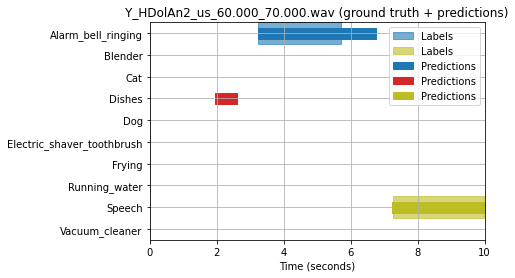

In [10]:
plot_labels_predictions(choice)

As we can observe, the results commented previously apply to our example: the model classifies well the correctly found events, but also creates an insertion about a non existent event: The model creates a *dishes* prediction when there is no label, and  also keeps the *alarm bell ringing* longer that the true label. There are two examples of insertions, leading to lower $F_1$ score.

We now select two different audios (the code is ready to change the number of audios and select $K$ new audios) and plot the labels and predictions of our system.

In [11]:
np.random.seed(234)
new_choices = np.random.choice(audio_names,2)
print("New choice filenames are: {}, {}".format(new_choices[0], new_choices[1]))

New choice filenames are: Y0cH_NlhhMAs_30.000_40.000.wav, Y0AkRWunFZPk_190.000_200.000.wav


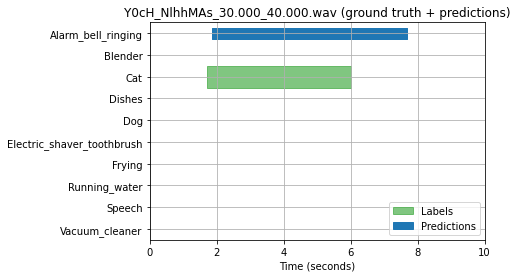

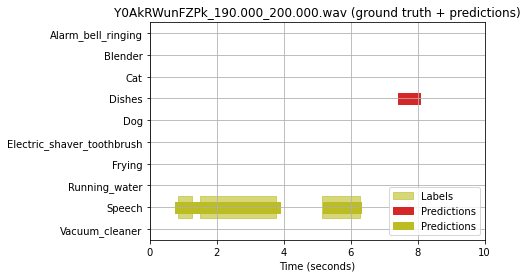

In [12]:
for file in new_choices:
    plot_labels_predictions(file, legend_location = 'lower right')

As we can see, in the **first** presented audio there are two mistakes:

- Firstly, the model is predicting a wrong label (it should be *cat*, it is predicting *alarm_bell_ringing*).
- Secondly, the prediction lasts longer than the actual label, leading to an *insertion*.

In the **second** audio, we see that the system is predicting the *speech* well, but it is inserting a *dishes* event that it is non existent.


# Conclusions

In this assignment we have learned to plot signals, mel-spectrograms, labels and predictions from a model. We have tested a specific DCASE system that tries to predict certain events in audios, discovering that the model creates many *insertions and deletions* in the audios, leading to low $F_1$ score.